# Analiza danych z targu rybnego
Zuzanna Trafas, 141329

Wykorzystuję dane z kaggle, które są obrobionymi danymi z "
SAS OnDemand for Academics"<br>
https://www.kaggle.com/aungpyaeap/fish-market?select=Fish.csv <br><br>

Są to dane obserwacyjne o 7 gatunkach ryb, pobrane z targu rybnego i opisane przez kolumny:
- Species: gatunek ryby, wartość nominalna
- Weight: waga w gramach
- Length1: długość w centymetrach
- Length2: długość w centymetrach
- Length3: długość w centymetrach
- Height: wysokość w centymetrach
- Width: szerokość w centymetrach

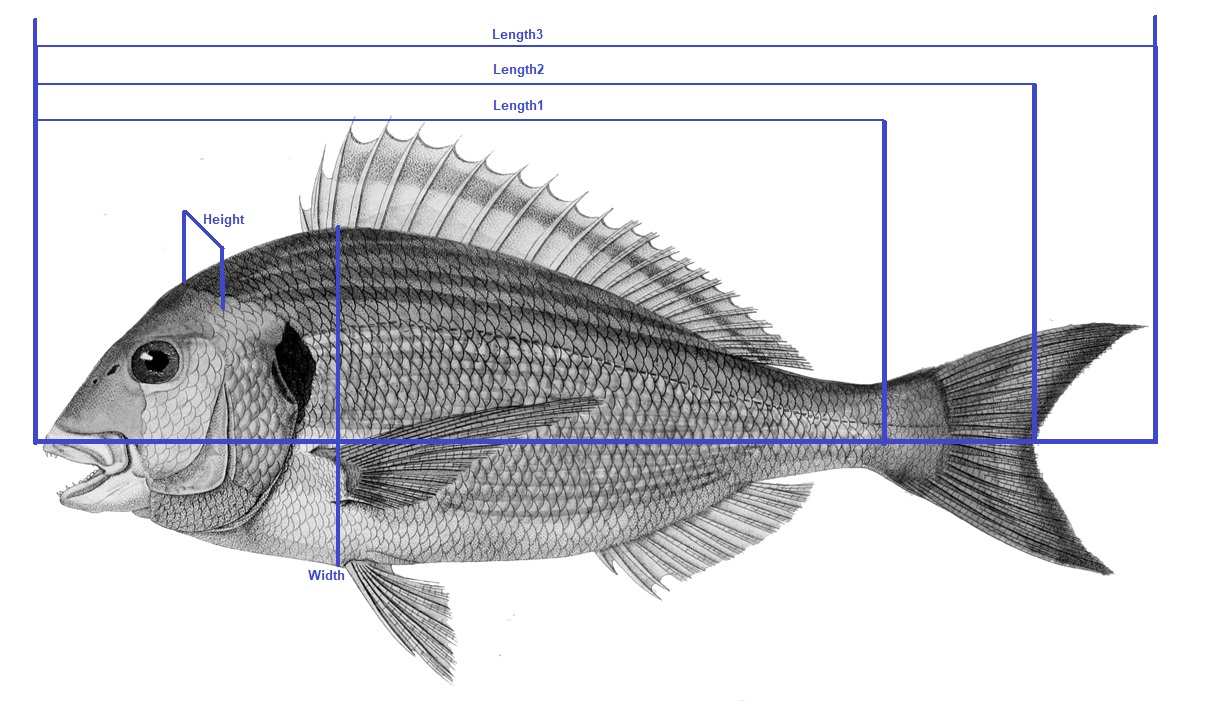

https://en.wikipedia.org/wiki/Gilt-head_bream 

## Analiza eksploracyjna

In [1]:
data <- read.table("Fish.csv", sep = ",", header = TRUE)
data[sample(nrow(data), 5),]

,Species,Weight,Length1,Length2,Length3,Height,Width
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
13,Bream,500.0,29.1,31.5,36.4,13.7592,4.3680
45,Roach,145.0,20.5,22.0,24.3,6.6339,3.5478
126,Perch,1100.0,40.1,43.0,45.5,12.5125,7.4165
156,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
85,Perch,125.0,19.0,21.0,22.5,5.6925,3.6675


In [2]:
summary(data$Species)

Bream    Parkki     Perch      Pike     Roach     Smelt Whitefish 
       35        11        56        17        20        14         6

Skupmy się tylko na tych gatunkach, dla których mamy więcej niż 30 obserwacji. Policzmy też korelację między otrzymanymi danymi:

In [3]:
fish <- data[(data$Species == "Perch" | data$Species == "Bream"),]
fish$Species <- droplevels(fish$Species, exclude = c("Parkki", "Pike", "Roach", "Smelt", "Whitefish"))

cor(fish[c("Weight", "Length1", "Length2", "Length3", "Height", "Width")])

,Weight,Length1,Length2,Length3,Height,Width
Weight,1.0000000,0.9521979,0.9558729,0.9516403,0.8153144,0.9449905
Length1,0.9521979,1.0000000,0.9992570,0.9807783,0.7794870,0.9661944
Length2,0.9558729,0.9992570,1.0000000,0.9853501,0.7948722,0.9656074
Length3,0.9516403,0.9807783,0.9853501,1.0000000,0.8832236,0.9366002
Height,0.8153144,0.7794870,0.7948722,0.8832236,1.0000000,0.7241166
Width,0.9449905,0.9661944,0.9656074,0.9366002,0.7241166,1.0000000


Widzimy, że wszystkie zmienne są ze sobą silnie skorelowane. Cechami, które będą nas najbardziej interesowały, są nas waga ryby (Weight) oraz jej długość - skorzystajmy z długości całkowitej (Length3).

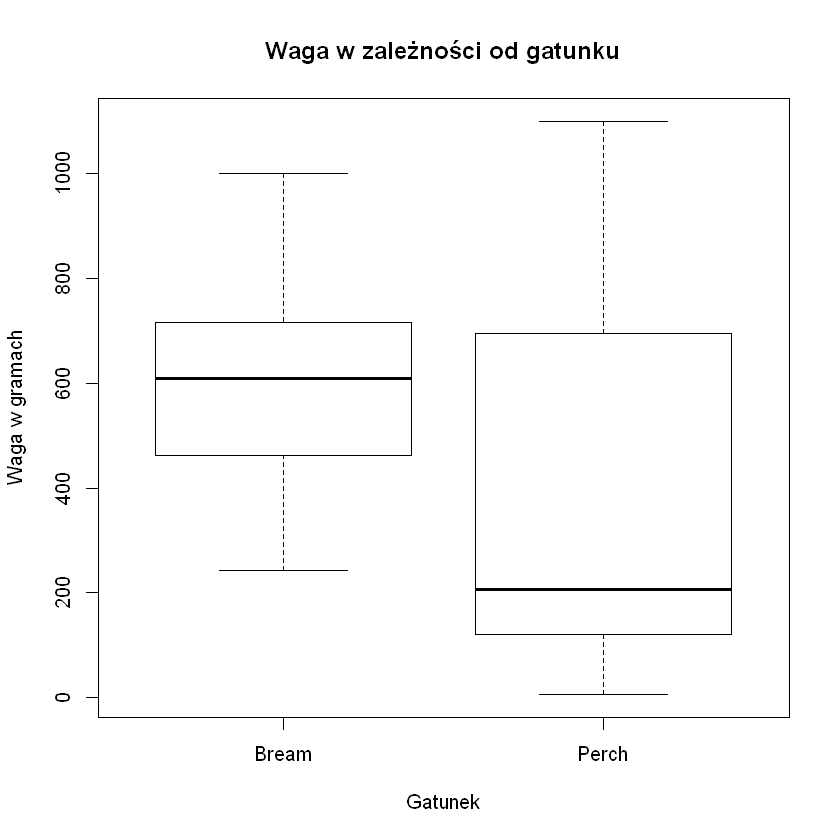

In [4]:
boxplot(Weight~Species, data = fish, main = "Waga w zależności od gatunku", xlab = "Gatunek", ylab = "Waga w gramach")

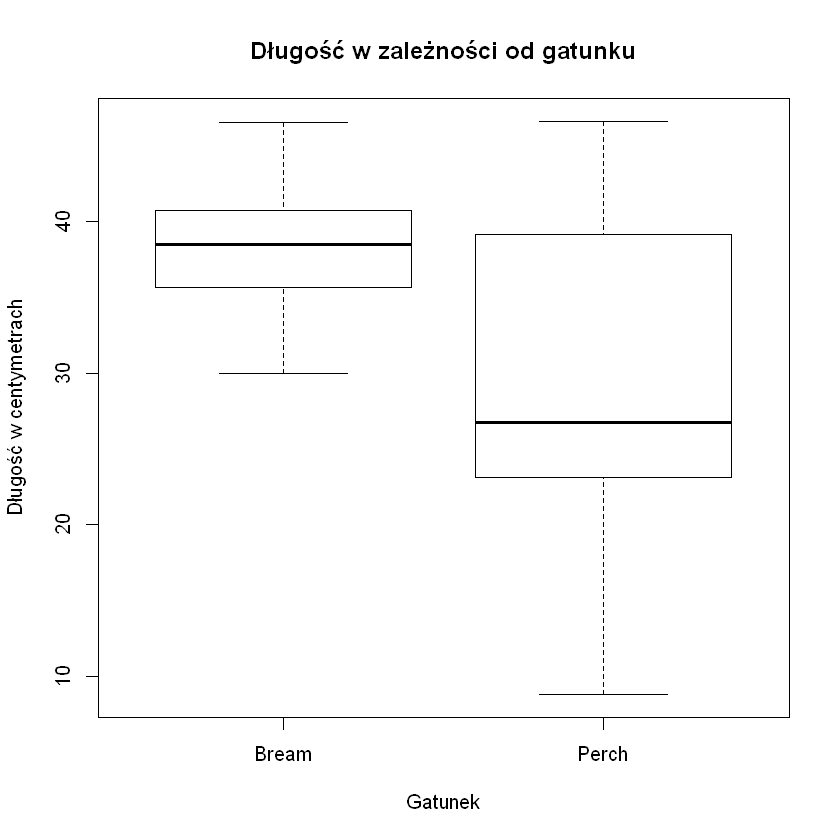

In [5]:
boxplot(Length3~Species, data = fish, main = "Długość w zależności od gatunku", 
        xlab = "Gatunek", ylab = "Długość w centymetrach")

Z wykresów pudełkowych możemy wyczytać, że okoń jest mniejszą i lżejszą rybą od leszcza, ale jego wielkość oraz waga są dużo bardziej zróżnicowane. Spójrzmy na histogramy tych cech:

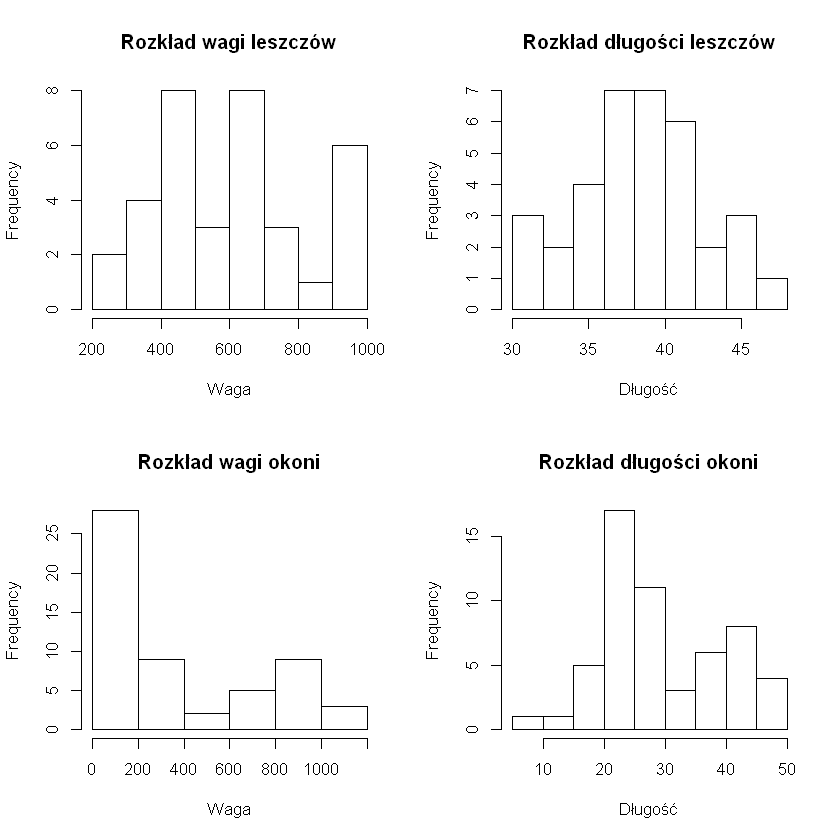

In [6]:
bream <- fish[fish$Species == "Bream",]
perch <- fish[fish$Species == "Perch",]

par(mfrow=c(2,2))
hist(bream$Weight, main = "Rozkład wagi leszczów", xlab = "Waga")
hist(bream$Length3, main = "Rozkład długości leszczów", xlab = "Długość")

hist(perch$Weight, main = "Rozkład wagi okoni", xlab = "Waga")
hist(perch$Length3, main = "Rozkład długości okoni", xlab = "Długość")

Od razu widać że rozkłady wagi oraz długości okoni bardzo odbiegają od rozkładu normalnego, natomiast dla leszczów wykonajmy wykres kwantyl-kwantyl (QQ plot).

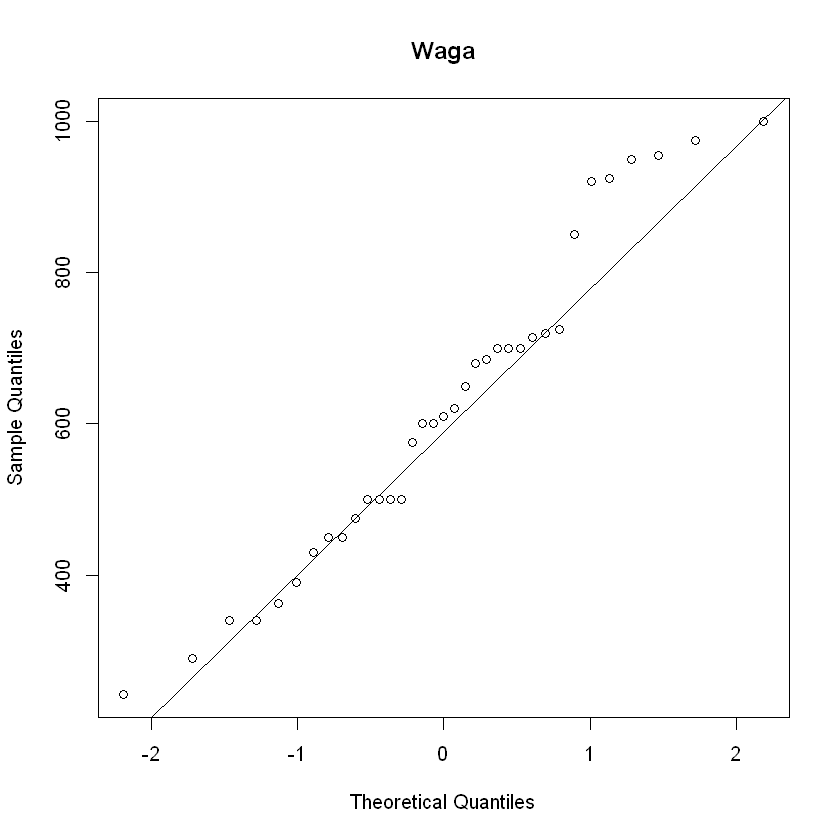

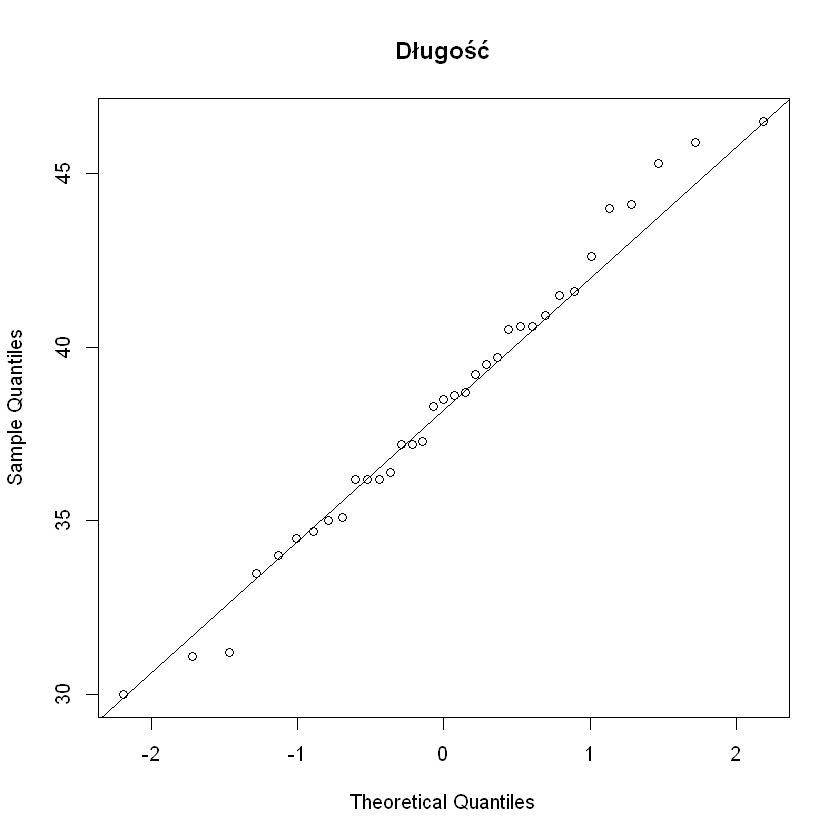

In [7]:
qqnorm(bream$Weight, main = "Waga")
qqline(bream$Weight)

qqnorm(bream$Length3, main = "Długość")
qqline(bream$Length3)

Widzimy, że rozkład wag bardziej odbiega od rozkładu normalnego, natomiast rozkład długości możemy spróbować nim przybliżyć.

## Test statystyczny

Jako, że nie znamy wariancji naszych danych, wykonajmy test T, żeby sprawdzić czy długość leszcza na naszym targu rybnym jest większa niż średnia długość tej ryby podawana na portalu "Suffolk Wildlife Trust". <br>
https://www.suffolkwildlifetrust.org/wildlife-explorer/freshwater-fish/bream <br><br>
Na portalu długość podana jest jako zakres 30-40 cm, do testu weźmy jego środek.<br>

$ H0: \mu = 35 $ <br>
$ H1: \mu > 35 $ <br>
Statystyka testowa: $ \large T_{n-1} = \frac{\bar{X} - \mu}{\frac{s}{\sqrt{n}}} $ <br>
Przyjęty poziom istotności: $ 5\% $


In [8]:
t.test(bream$Length3, mu = 35, alternative = "greater")


	One Sample t-test

data:  bream$Length3
t = 4.7727, df = 34, p-value = 1.69e-05
alternative hypothesis: true mean is greater than 35
95 percent confidence interval:
 37.16589      Inf
sample estimates:
mean of x 
 38.35429 


Z p-wartością równą $ 1.69 * 10^{-5} $ odrzucamy hipotezę zerową. Być może różnica w wielkości wynika z tego, że na targu rybnym sprzedawane są jedynie dorosłe i duże osobniki? Nie dysponujemy próbą losową prostą dla całej populacji leszczów, a jedynie małą próbą pobraną z konkretnego miejsca, nie możemy więc na jej podstawie wyciągnąć wniosków o całej populacji.

## Analiza modelu regresji

Sprawdźmy, czy dla wybranych przez nas gatunkach ryb uda się przeprowadzić analizę regresji. Zacznijmy od wykonania wykresu rozrzutu dla długości oraz wagi ryby.

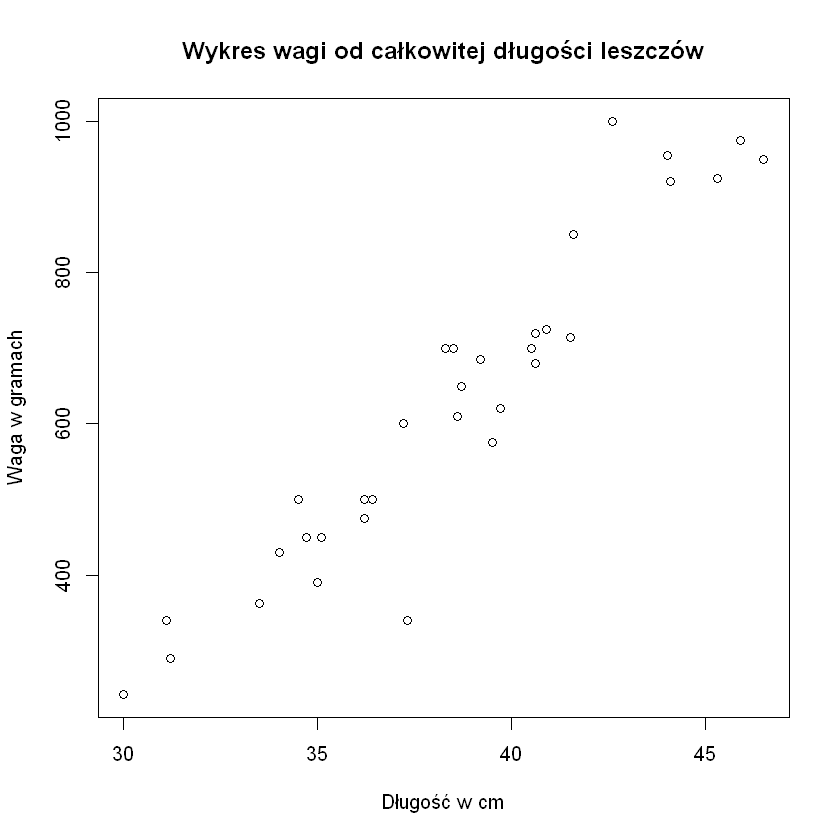

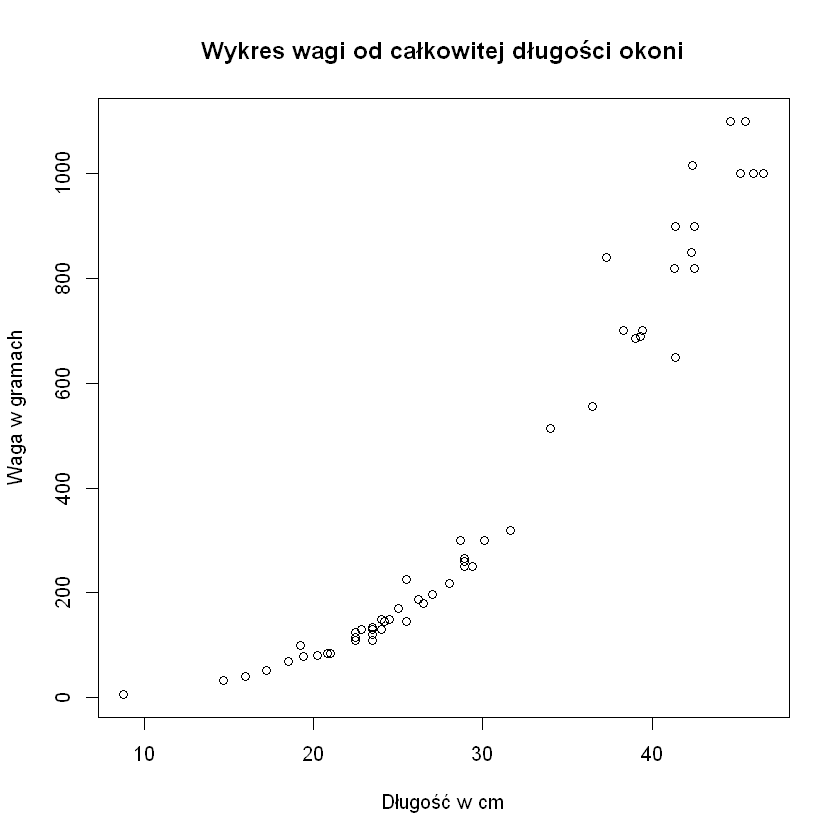

In [9]:
plot(Weight ~ Length3, bream, main = "Wykres wagi od całkowitej długości leszczów", 
     xlab = "Długość w cm", ylab = "Waga w gramach")
plot(Weight ~ Length3, perch, main = "Wykres wagi od całkowitej długości okoni", 
     xlab = "Długość w cm", ylab = "Waga w gramach")

Dla obu gatunków istnieje zależność między zmiennymi, natomiast tylko dla leszczów jest ona liniowa. Spróbujmy wyznaczyć dla nich współczynniki regresji liniowej.

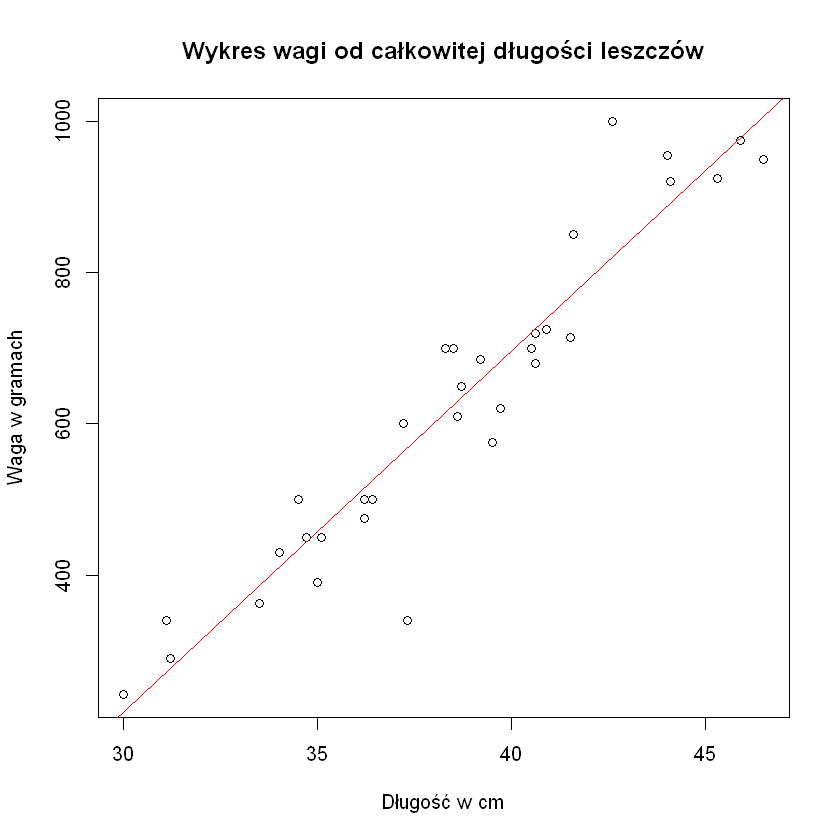

In [10]:
model_bream <- lm(Weight ~ Length3, data = bream)
plot(Weight ~ Length3, bream, main = "Wykres wagi od całkowitej długości leszczów", 
     xlab = "Długość w cm", ylab = "Waga w gramach")
abline(model_bream, col = "red")

Jak na razie wygląda dobrze. Wykonajmy wykresy diagnostyczne żeby sprawdzić założenia regresji.

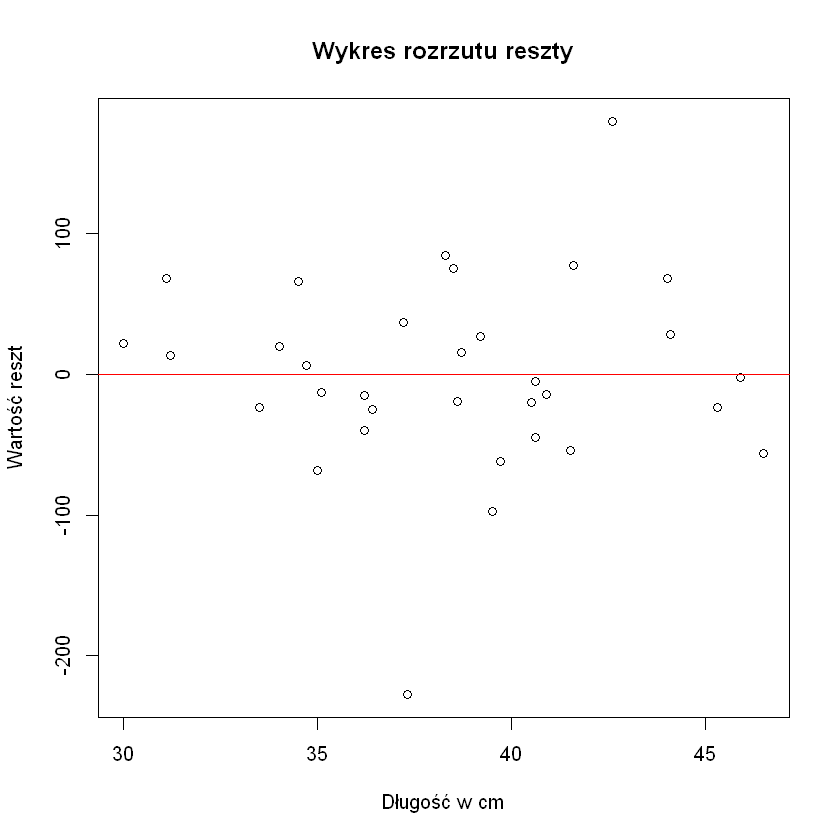

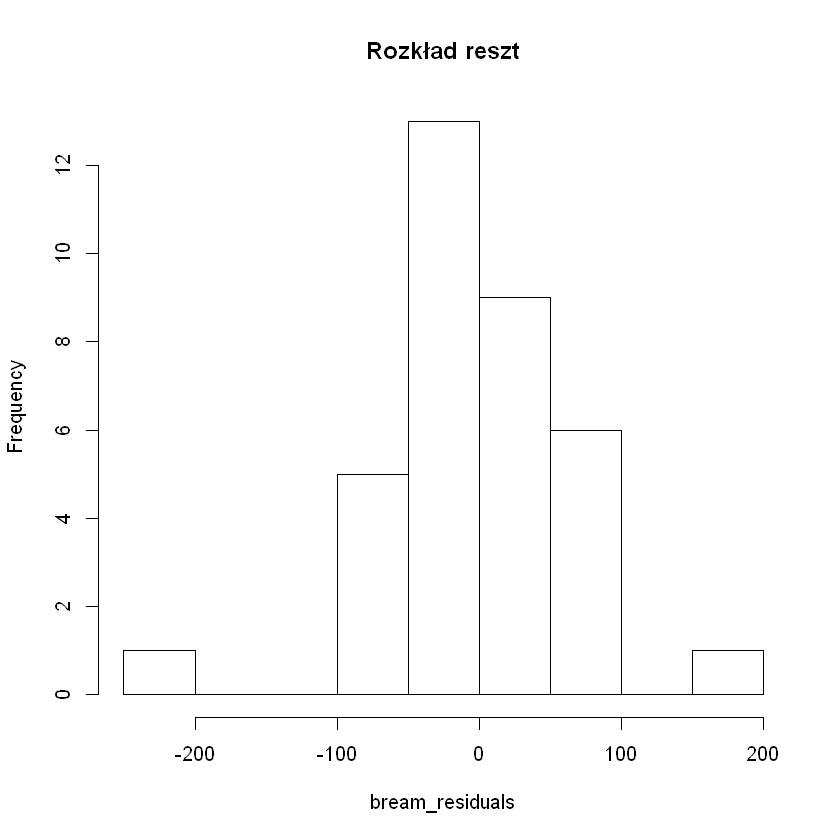

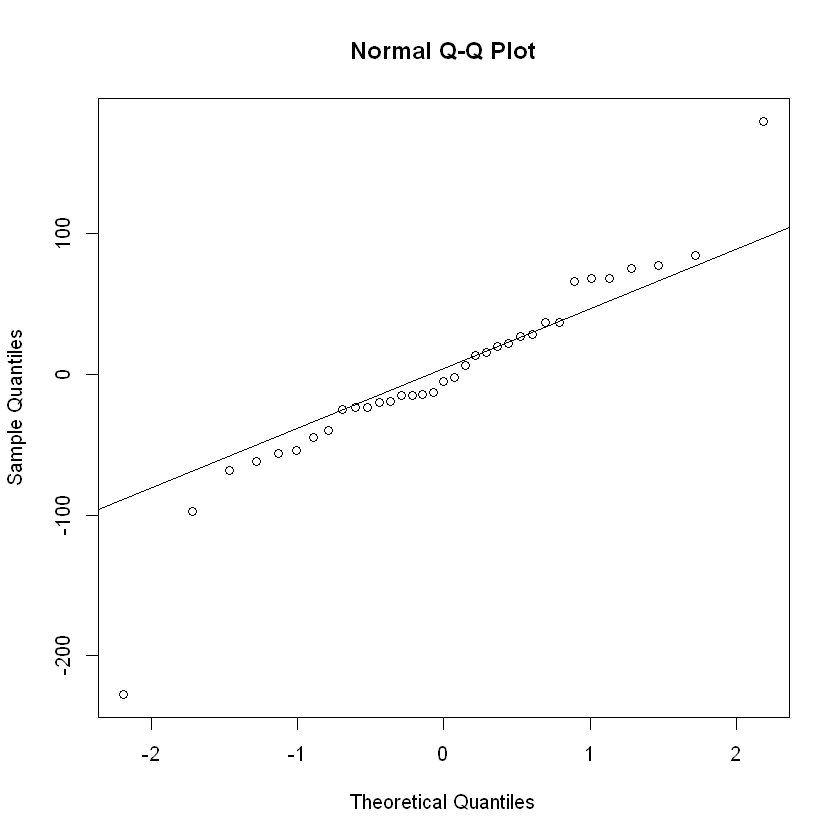

In [11]:
bream_residuals <- bream$Weight - predict(model_bream, newdata=data.frame(Length3 = bream$Length3))

plot(bream_residuals ~ bream$Length3, main = "Wykres rozrzutu reszty", xlab = "Długość w cm", ylab = "Wartość reszt")
abline(h=0, col = "red")

hist(bream_residuals, main = "Rozkład reszt")

qqnorm(bream_residuals)
qqline(bream_residuals)

Wykresy wyglądałyby naprawdę dobrze, gdyby nie dwie obserwacje odstające. Pomijając te dwie obserwacje, wszystkie założenia regresji byłyby spełnione. Sprawdźmy parametry naszego modelu:

In [12]:
summary(model_bream)


Call:
lm(formula = Weight ~ Length3, data = bream)

Residuals:
    Min      1Q  Median      3Q     Max 
-227.59  -24.26   -4.85   32.77  179.84 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1209.97     108.39  -11.16 9.61e-13 ***
Length3        47.66       2.81   16.96  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 68.13 on 33 degrees of freedom
Multiple R-squared:  0.8971,	Adjusted R-squared:  0.8939 
F-statistic: 287.6 on 1 and 33 DF,  p-value: < 2.2e-16


Pomimo dwóch obserwacji odstających, nasz model radzi sobie bardzo dobrze - ma wysokie $ R^2 $ oraz jest istotny statystycznie. A co gdybyśmy dodali do niego resztę cech?

In [13]:
multiple_model_bream <- lm(Weight ~ Length1 + Length2 + Length3 + Height + Width, data = bream)
summary(multiple_model_bream)


Call:
lm(formula = Weight ~ Length1 + Length2 + Length3 + Height + 
    Width, data = bream)

Residuals:
     Min       1Q   Median       3Q      Max 
-165.409  -27.599   -6.056   24.793  114.554 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -939.44     162.62  -5.777 2.94e-06 ***
Length1        16.19      49.40   0.328  0.74551    
Length2        17.97      53.70   0.335  0.74034    
Length3       -21.19      42.26  -0.501  0.61988    
Height         64.20      17.84   3.598  0.00118 ** 
Width          57.05      42.14   1.354  0.18622    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 53.96 on 29 degrees of freedom
Multiple R-squared:  0.9433,	Adjusted R-squared:  0.9335 
F-statistic: 96.42 on 5 and 29 DF,  p-value: < 2.2e-16


Widzimy, że $ R^2 $ urosło, ale znaczenie cechy Length3 w modelu znacznie zmalało. Dlaczego? Spójrzmy jeszcze raz na korelację między zmiennymi:

In [14]:
cor(bream[c("Weight", "Length1", "Length2", "Length3", "Height", "Width")])

,Weight,Length1,Length2,Length3,Height,Width
Weight,1.0000000,0.9370500,0.9462561,0.9471359,0.9645275,0.9253033
Length1,0.9370500,1.0000000,0.9977127,0.9963528,0.9393835,0.8992981
Length2,0.9462561,0.9977127,1.0000000,0.9982367,0.9503909,0.9157165
Length3,0.9471359,0.9963528,0.9982367,1.0000000,0.9529003,0.9212056
Height,0.9645275,0.9393835,0.9503909,0.9529003,1.0000000,0.9266920
Width,0.9253033,0.8992981,0.9157165,0.9212056,0.9266920,1.0000000


Zmienne objaśniające są od siebie silnie zależne. Korelacja nie pogarsza siły predykcyjnej naszego modelu, ale wpływa na wartości statystyk testowych pojedynczych predyktorów, nie możemy więc w prosty sposób ustalić, które cechy są nadmiarowe.
***

A co z okoniami? Możemy spróbować przekształcić zmienną X aby uzyskać liniowość danych:

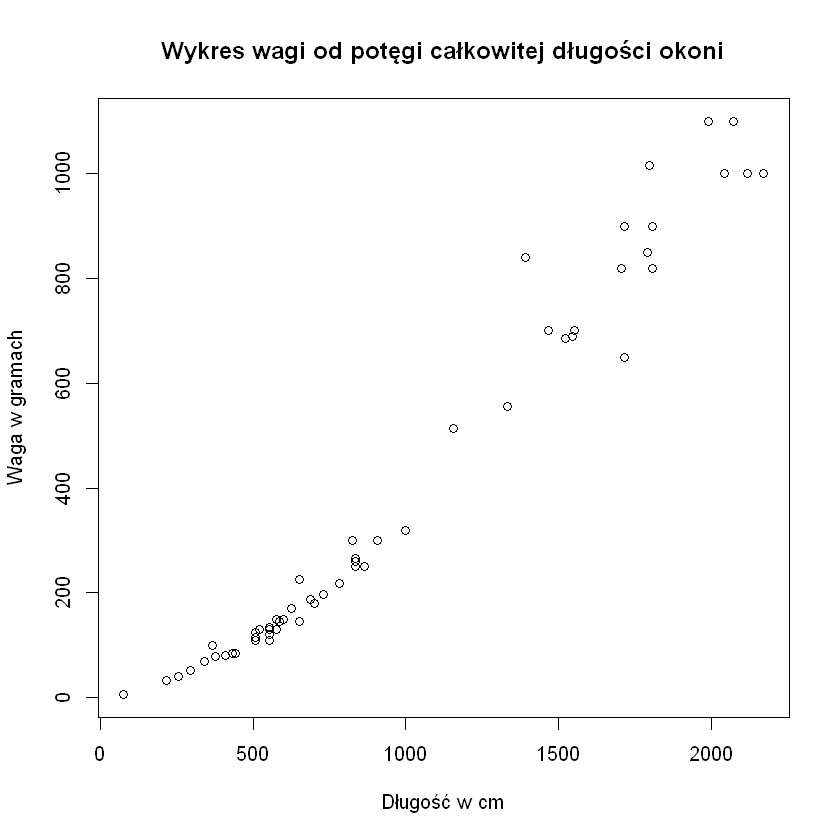

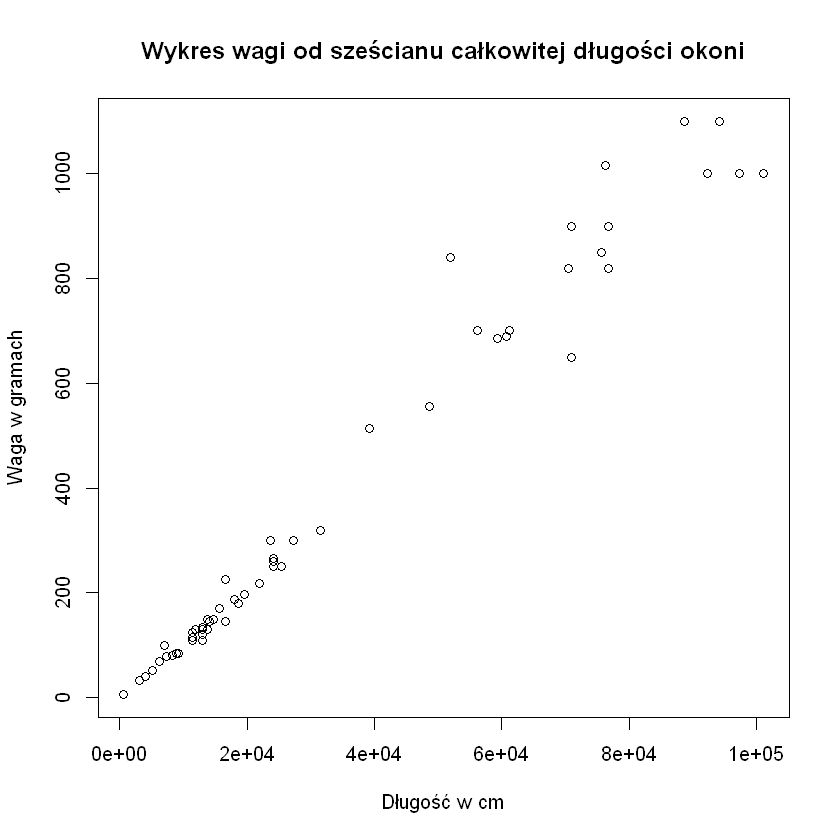

In [15]:
Length3_square <- perch$Length3^2
plot(perch$Weight ~ Length3_square, main = "Wykres wagi od potęgi całkowitej długości okoni", 
     xlab = "Długość w cm", ylab = "Waga w gramach")

Length3_cube <- perch$Length3^3
plot(perch$Weight ~ Length3_cube, main = "Wykres wagi od sześcianu całkowitej długości okoni", 
     xlab = "Długość w cm", ylab = "Waga w gramach")

Dla zmiennej objaśniającej w postaci sześcianu długości ryby, zależność wydaje się być liniowa, jednak już na pierwszy rzut oka można zauważyć brak homoskedastyczności. Założenia regresji nie są spełnione, nie będziemy więc przeprowadzać dalszej analizy.

## Podsumowanie
Udało nam się przeprowadzić analizę eksploracyjną danych dla dwóch gatunków - leszczów i okoni. Przeprowadziliśmy test i stwierdziliśmy, że rozmiar ryb z targu, z którego zostały pobrane dane, jest większy od rozmiaru podawanego na stronie "Suffolk Wildlife Trust". Udało nam się się również przeprowadzić analizę modelu regresji liniowej dla jednej i wielu zmiennych objaśniających dla wagi leszczów.